In [ ]:
import os
import cv2   #opencv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.optimizers import Adam
from PIL import Image

In [ ]:
labels_dict = {
    'Actinic keratosis': 0,
    'Atopic Dermatitis': 1,
    'Benign keratosis': 2,
    'Dermatofibroma': 3,
    'Melanocytic nevus': 4,
    'Melanoma': 5,
    'Squamous Cell Carcinoma': 6,
    'Tinea Ringworm Candidiasis': 7,
    'Vascular lesion': 8
}

In [ ]:
data_dir = '/content/drive/MyDrive/Split_smol/train'

In [ ]:
X = []
y = []

for folder, label in labels_dict.items():
    folder_path = os.path.join(data_dir, folder)
    if not os.path.isdir(folder_path):
        print(f"Directory '{folder}' not found in '{data_dir}'. Skipping...")
        continue

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to read image: {image_path}. Skipping...")
            continue

        img = cv2.resize(img, (227, 227))  # Resize images to (227, 227)
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X_shuffled = X[indices]
y_shuffled = y[indices]   #shuffle to unsure that train and testing data will not follow same order

split_index = int(0.8 * len(X_shuffled))  # Use 80% of the data for training
X_train, X_val = X_shuffled[:split_index], X_shuffled[split_index:]
y_train, y_val = y_shuffled[:split_index], y_shuffled[split_index:]

In [ ]:
datagen = ImageDataGenerator(        #for increaseing the amount the data available
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

#print(len(train_generator))
#print(len(val_generator))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(227, 227, 3))   #googlenet

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False        #to freeze the data for no longer changes


In [ ]:

x = base_model.output  #layer implementation
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(labels_dict), activation='softmax')(x)   #softmax - gives probability distribution to determine the class


In [ ]:
model = Model(inputs=base_model.input, outputs=output)


In [ ]:
from tensorflow.keras.optimizers import Adagrad
optimizer = Adagrad(learning_rate=0.01, initial_accumulator_value=0.1, epsilon=1e-07)  #epsilon for numerical stability

In [ ]:

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #sparse_categorical crossentroy - multi class classification


In [ ]:
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras.models import Sequential
# vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(227, 227, 3))
# for layer in vgg19_model.layers:
#     layer.trainable = False

# # Create a new model on top
# with tf.device('/device:GPU:0'):
#     model_vgg19 = Sequential([
#         vgg19_model,
#         GlobalAveragePooling2D(),
#         Dense(512, activation='relu'),
#         Dense(len(labels_dict), activation='softmax')
#     ])

In [ ]:
# model_vgg19.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,     #the number of training iterations the model will go through.
    validation_data=val_generator
)


Epoch 1/50
16/16 [==============================] - 9s 568ms/step - loss: 0.2244 - accuracy: 0.9290 - val_loss: 0.6692 - val_accuracy: 0.7742
Epoch 2/50
16/16 [==============================] - 7s 440ms/step - loss: 0.2351 - accuracy: 0.9189 - val_loss: 0.8002 - val_accuracy: 0.7097
Epoch 3/50
16/16 [==============================] - 9s 531ms/step - loss: 0.1967 - accuracy: 0.9391 - val_loss: 0.7118 - val_accuracy: 0.7258
Epoch 4/50
16/16 [==============================] - 9s 545ms/step - loss: 0.2385 - accuracy: 0.9148 - val_loss: 0.7522 - val_accuracy: 0.7500
Epoch 5/50
16/16 [==============================] - 8s 497ms/step - loss: 0.2174 - accuracy: 0.9331 - val_loss: 0.8310 - val_accuracy: 0.7419
Epoch 6/50
16/16 [==============================] - 8s 534ms/step - loss: 0.2680 - accuracy: 0.9026 - val_loss: 0.7033 - val_accuracy: 0.7500
Epoch 7/50
16/16 [==============================] - 8s 517ms/step - loss: 0.2616 - accuracy: 0.9087 - val_loss: 0.6691 - val_accuracy: 0.7177
Epoch 

In [ ]:
test_dir = '/content/drive/MyDrive/Split_smol/val'

In [ ]:
X_test = []
y_test = []

for folder, label in labels_dict.items():
    folder_path = os.path.join(data_dir, folder)
    if not os.path.isdir(folder_path):
        print(f"Directory '{folder}' not found in '{data_dir}'. Skipping...")
        continue

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to read image: {image_path}. Skipping...")
            continue

        img = cv2.resize(img, (227, 227))  # Resize images to (227, 227)
        X_test.append(img)
        y_test.append(label)

X_test = np.array(X)
y_test = np.array(y)

In [ ]:
test_generator = datagen.flow(X_test, y_test, batch_size=32)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

20/20 [==============================] - 8s 421ms/step - loss: 0.2516 - accuracy: 0.9238
Test loss: 0.2516041696071625
Test accuracy: 0.9238249659538269


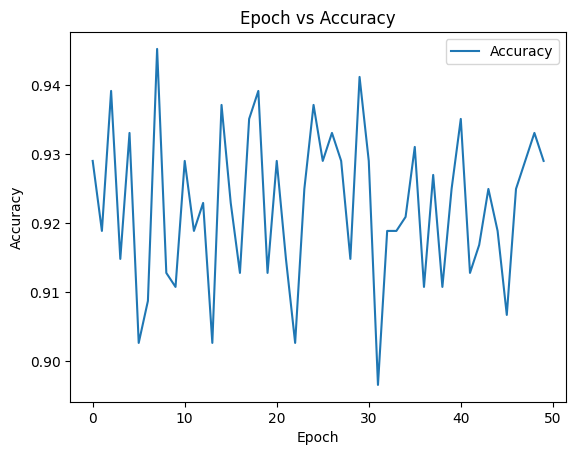

In [ ]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
model.save('skindisease_model_inceptionv3.h5')

In [ ]:
new_model = tf.keras.models.load_model('skindisease_model_inceptionv3.h5')

In [ ]:
import PIL
image_path = '/content/drive/MyDrive/Split_smol/val/Benign keratosis/ISIC_0014605_downsampled.jpg'
test_image = PIL.Image.open(image_path)
resized_image = test_image.resize((227, 227))
resized_image = np.array(resized_image) / 255.0
resized_image = resized_image[np.newaxis, ...]
prediction = new_model.predict(resized_image)
predicted_class_index = np.argmax(prediction)
print('Predicted class index:', predicted_class_index)

1/1 [==============================] - 0s 25ms/step
Predicted class index: 2


In [ ]:
disease_info = {
    'Actinic keratosis': {
        'severity': 6,
        'diagnosis': 'Actinic keratosis (AK) is a precancerous skin condition caused by exposure to ultraviolet (UV) rays. It appears as rough, scaly patches on the skin and is considered a warning sign of potential skin cancer. Early detection and treatment are crucial to prevent progression to skin cancer.',
        'precautions': ['Limit sun exposure', 'Use sunscreen', 'Wear protective clothing'],
        'preventions': ['Regular skin checks', 'Avoid tanning beds']
    },
    'Atopic Dermatitis': {
        'severity': 4,
        'diagnosis': 'Atopic dermatitis, also known as eczema, is a chronic skin condition characterized by inflammation, itching, and redness. It often occurs in individuals with a personal or family history of allergies or asthma. Management involves keeping the skin moisturized, avoiding triggers, and using prescribed medications as needed.',
        'precautions': ['Keep skin moisturized', 'Avoid irritants', 'Manage stress'],
        'preventions': ['Avoid triggers', 'Regular bathing']
    },
    'Benign keratosis': {
        'severity': 2,
        'diagnosis': 'Benign keratosis, also known as seborrheic keratosis or senile wart, is a non-cancerous skin growth that commonly appears as a waxy, brown, or black growth on the face, chest, shoulders, or back. It is typically harmless but can be cosmetically bothersome. Treatment may be desired for cosmetic reasons.',
        'precautions': ['Avoid picking or scratching', 'Use moisturizers'],
        'preventions': ['Regular skin exams']
    },
    'Dermatofibroma': {
        'severity': 3,
        'diagnosis': 'Dermatofibroma is a benign skin lesion that often appears as a small, firm bump on the skin, typically on the legs. It is thought to be a result of minor trauma to the skin. Dermatofibromas are usually harmless and do not require treatment unless they cause symptoms or cosmetic concerns.',
        'precautions': ['Avoid trauma to the skin'],
        'preventions': ['Regular skin checks']
    },
    'Melanocytic nevus': {
        'severity': 1,
        'diagnosis': 'Melanocytic nevus, commonly known as a mole, is a benign skin growth that develops when pigment-producing cells (melanocytes) cluster together. Moles are usually brown or black and can appear anywhere on the body. While most moles are harmless, changes in size, shape, or color should be evaluated by a dermatologist.',
        'precautions': ['Monitor changes in moles', 'Use sunscreen'],
        'preventions': ['Avoid sun exposure']
    },
    'Melanoma': {
        'severity': 9,
        'diagnosis': 'Melanoma is a type of skin cancer that develops from melanocytes, the pigment-producing cells in the skin. It often appears as an irregularly shaped mole or dark spot that changes in size, shape, or color. Melanoma can spread to other parts of the body if not detected and treated early. Early detection and prompt treatment are critical for better outcomes.',
        'precautions': ['Regular skin checks', 'Protect skin from UV radiation'],
        'preventions': ['Avoid tanning beds']
    },
    'Squamous cell carcinoma': {
        'severity': 8,
        'diagnosis': 'Squamous cell carcinoma (SCC) is a common form of skin cancer that arises from the squamous cells in the outer layer of the skin. It often appears as a firm, red nodule or a scaly, crusty lesion. SCC can grow and spread if not treated early. Early detection and prompt treatment are essential to prevent complications.',
        'precautions': ['Use sunscreen', 'Protect skin from UV radiation'],
        'preventions': ['Avoid tobacco and excessive alcohol consumption']
    },
    'Tinea Ringworm Candidiasis': {
        'severity': 5,
        'diagnosis': 'Tinea is a fungal infection that can affect the skin, scalp, or nails. It is commonly known as ringworm when it affects the skin. Ringworm appears as a red, circular rash with raised edges and a clear center. It is highly contagious and can spread through direct contact with an infected person or contaminated objects. Treatment typically involves antifungal medications applied to the affected area.',
        'precautions': ['Keep skin clean and dry', 'Avoid sharing personal items'],
        'preventions': ['Practice good hygiene']
    },
    'Vascular lesion': {
        'severity': 7,
        'diagnosis': 'Vascular lesions are abnormalities of the skin caused by an abnormal development of blood vessels. They can appear as birthmarks, port wine stains, or hemangiomas. Most vascular lesions are harmless, but some may cause cosmetic concerns or other complications. Treatment options include laser therapy or surgical removal, depending on the type and severity of the lesion.',
        'precautions': ['Protect skin from trauma'],
        'preventions': ['Regular skin checks']
    }
}


In [ ]:
predicted_label = {v: k for k, v in labels_dict.items()}.get(predicted_class_index)
print('Predicted label:', predicted_label)

Predicted label: Benign keratosis


In [ ]:
if predicted_label:
    print('Predicted label:', predicted_label)
    info = disease_info.get(predicted_label)
    if info:
        print('Diagnosis:', info['diagnosis'])
        print('Severity:', info['severity'])
        print('Precautions:')
        for precaution in info['precautions']:
            print('-', precaution)
        print('Preventions:')
        for prevention in info['preventions']:
            print('-', prevention)
    else:
        print('Information not available for this disease.')
else:
    print('Unable to determine the predicted label.')

Predicted label: Benign keratosis
Diagnosis: Benign keratosis, also known as seborrheic keratosis or senile wart, is a non-cancerous skin growth that commonly appears as a waxy, brown, or black growth on the face, chest, shoulders, or back. It is typically harmless but can be cosmetically bothersome. Treatment may be desired for cosmetic reasons.
Severity: 2
Precautions:
- Avoid picking or scratching
- Use moisturizers
Preventions:
- Regular skin exams
